In [ ]:
# Install required package
!pip install easyocr torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
# Imports
from scipy.fft import fft2, ifft2, fftshift
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage import measure
from time import time
import numpy as np
import easyocr
import torch
import re
import cv2

# 1. Plate Recognition

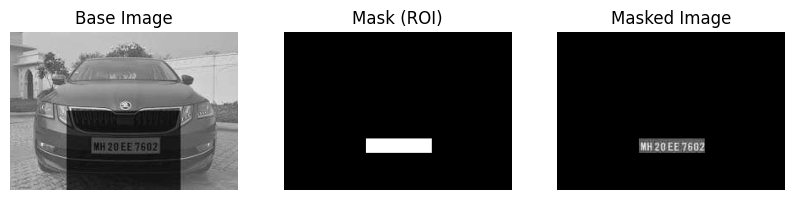

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompletePlate: MH20 EE 7602, confidence: 0.34


In [ ]:
image = cv2.imread('car.jpg', cv2.IMREAD_GRAYSCALE)

# Compute the 2D Fourier Transform of the image
ft_image = fft2(image)

# Shift the Fourier transform to center the low frequencies
ft_image_shifted = fftshift(ft_image)

# Compute the magnitude spectrum for visualization
magnitude_spectrum = np.log(1 + np.abs(ft_image_shifted))

# Create a high-pass circular mask to remove low frequencies
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

# Cutoff frequency for the high-pass filter
cutoff_frequency = 0.001

# Create a circular mask that removes low frequencies
Y, X = np.ogrid[:rows, :cols]
distance_from_center = np.sqrt((X - ccol)**2 + (Y - crow)**2)
mask = np.ones((rows, cols))
mask[distance_from_center <= cutoff_frequency] = 0

# Apply the high-pass filter in the frequency domain
ft_image_filtered = ft_image_shifted * mask

# Inverse Fourier Transform
filtered_image = np.abs(ifft2(fftshift(ft_image_filtered)))

# Convert the filtered image to uint8 format
filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Create a region of interest for a specific region
mask = np.zeros(filtered_image.shape, dtype="uint8")
start_x, start_y, end_x, end_y = 97, 126, 174, 142
cv2.rectangle(mask, (start_x, start_y), (end_x, end_y), 255, -1)

# Apply AND operation to isolate the ROI
masked_image = cv2.bitwise_and(filtered_image, mask)

cv2.imwrite('masked_img.png', masked_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Base Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask (ROI)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_image, cmap='gray')
plt.title('Masked Image')
plt.axis('off')

plt.show()

# Initialize the reader for English and perform OCR
reader = easyocr.Reader(['en'])
results = reader.readtext('masked_img.png')

for _, text, confidence in results:
    print(f"Plate: {text}, confidence: {confidence:.2f}")

# 2. Counting Stars

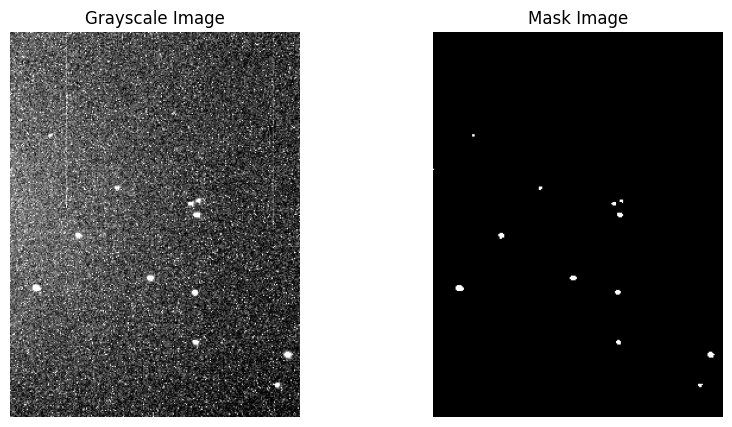

Number of stars: 13
Star 1: (86.5, 33.5)
Star 2: (115.0, 0.0)
Star 3: (130.875, 89.875)
Star 4: (141.71428571428572, 158.14285714285714)
Star 5: (144.0, 151.8)
Star 6: (153.41176470588235, 156.88235294117646)
Star 7: (170.8421052631579, 57.05263157894737)
Star 8: (206.5, 117.5)
Star 9: (215.10344827586206, 21.82758620689655)
Star 10: (218.5, 155.0)
Star 11: (260.61538461538464, 155.6153846153846)
Star 12: (271.0869565217391, 233.2173913043478)
Star 13: (296.77777777777777, 224.33333333333334)


In [ ]:
pixels = []

with open('input1.txt', 'r') as file:
    dimensions_line = file.readline().strip()
    width, height, _ = map(int, dimensions_line.split())
    for line in file:
        cleaned_line = re.sub(r'[(),]', '', line).strip()
        values = cleaned_line.split()
        pixels.extend([int(value) for value in values])

pixels = np.array(pixels, dtype=np.uint8)

# Reshape the array into (height, width, 3) for RGB format
image_rgb = pixels.reshape((width, height, 3))

gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Apply a binary threshold to isolate stars
_, star_mask = cv2.threshold(blurred_image, 180, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(star_mask, cmap='gray')
plt.title('Mask Image')
plt.axis('off')

plt.show()

# Label connected components in the star mask and 'connectivity=2' ensures 8-connectivity
labeled_mask = measure.label(star_mask, connectivity=2)

# Count the unique labels (excluding the background label 0)
num_stars = np.max(labeled_mask)  # The maximum label is the count of stars

print(f"Number of stars: {num_stars}")

# Get properties of labeled regions
regions = measure.regionprops(labeled_mask)

# Extract coordinates of the centroids
star_coordinates = [region.centroid for region in regions]

for i, (y, x) in enumerate(star_coordinates, start=1):
    print(f"Star {i}: ({y}, {x})")

# 3. NLM

In [ ]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Resize the image if needed (optional, e.g., to 256x256)
    # img = cv2.resize(img, (256, 256))  # Change size as needed

    # Convert to a PyTorch tensor and normalize to [0, 1] range
    img_tensor = torch.from_numpy(img).float() / 255.0  # Shape: [H, W, C]

    # Move channel dimension to be first: [C, H, W]
    img_tensor = img_tensor.permute(2, 0, 1)

    # Add batch dimension: [1, C, H, W]
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor

def NLM(img, k_size=7, s_size=101, beta=0.1, device = 'cpu'):
    img = img.to(device)
    pad = s_size // 2
    img_pad = torch.nn.functional.pad(img, (pad, pad, pad, pad), mode='reflect')
    out = torch.zeros_like(img)
    w_sum = torch.zeros_like(img)

    for dx in range(-pad, pad + 1):
        for dy in range(-pad, pad + 1):
            shifted = img_pad[:, :, pad + dx : pad + dx + img.size(2), pad + dy : pad + dy + img.size(3)]
            diff = (img - shifted) ** 2
            w = torch.exp(-diff / (beta ** 2))
            out += w * shifted
            w_sum += w

    out /= w_sum
    return out

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

add_noise = T.Compose([
    T.Lambda(lambda x: torch.clamp(x, 0.0, 1.0)),
    T.Lambda(AddGaussianNoise(mean=0.0, std=0.1)),
    T.Lambda(lambda x: torch.clamp(x, 0.0, 1.0))
])

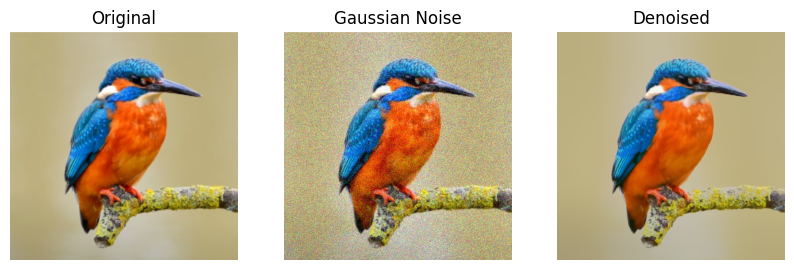

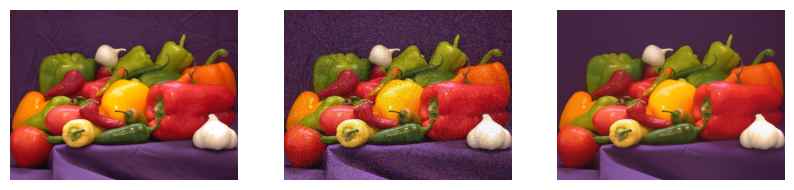

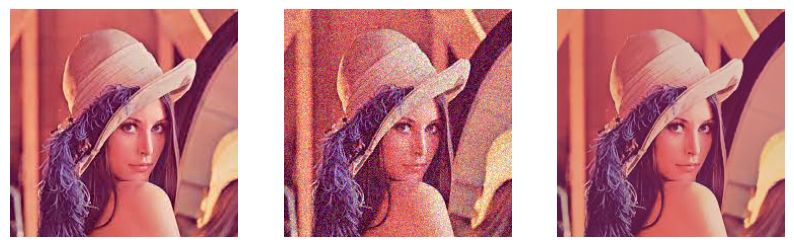

GPU Execution Time: 4.504268646240234


In [ ]:
start_time = time()

torch.cuda.synchronize()

image1 = load_image('bird.jpg')
image2 = load_image('vegetables.jpg')
image3 = load_image('woman.jpg')

base_image1 = cv2.imread('bird.jpg')
base_image1 = cv2.cvtColor(base_image1, cv2.COLOR_BGR2RGB)
base_image2 = cv2.imread('vegetables.jpg')
base_image2 = cv2.cvtColor(base_image2, cv2.COLOR_BGR2RGB)
base_image3 = cv2.imread('woman.jpg')
base_image3 = cv2.cvtColor(base_image3, cv2.COLOR_BGR2RGB)

noisy_image1 = add_noise(image1)
noisy_image2 = add_noise(image2)
noisy_image3 = add_noise(image3)

denoised_image1 = NLM(image1, device = 'cuda').cuda()
denoised_image2 = NLM(image2, device = 'cuda').cuda()
denoised_image3 = NLM(image3, device = 'cuda').cuda()

noisy_image1_np = noisy_image1.squeeze(0).permute(1, 2, 0).numpy()
noisy_image2_np = noisy_image2.squeeze(0).permute(1, 2, 0).numpy()
noisy_image3_np = noisy_image3.squeeze(0).permute(1, 2, 0).numpy()

denoised_img1_np = denoised_image1.squeeze(0).permute(1, 2, 0).cpu().numpy()
denoised_img2_np = denoised_image2.squeeze(0).permute(1, 2, 0).cpu().numpy()
denoised_img3_np = denoised_image3.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(base_image1)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image1_np)
plt.title('Gaussian Noise')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img1_np)
plt.title('Denoised')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(base_image2)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image2_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img2_np)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(base_image3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image3_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img3_np)
plt.axis('off')
plt.show()

end_time = time() - start_time
print(f'GPU Execution Time: {end_time}')